In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/slideseq_spleen.h5ad')
adata

AnnData object with n_obs × n_vars = 6891 × 3000
    obs: 'n_genes', 'n_UMIs', 'Cell_Type', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'log10_n_UMIs', 'log10_n_genes', 'donor_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'clusters'
    var: 'gene', 'n_beads', 'n_UMIs', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'fea

In [4]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

2024-11-25 17:56:44.057478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 17:56:44.108836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 17:56:46.400095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


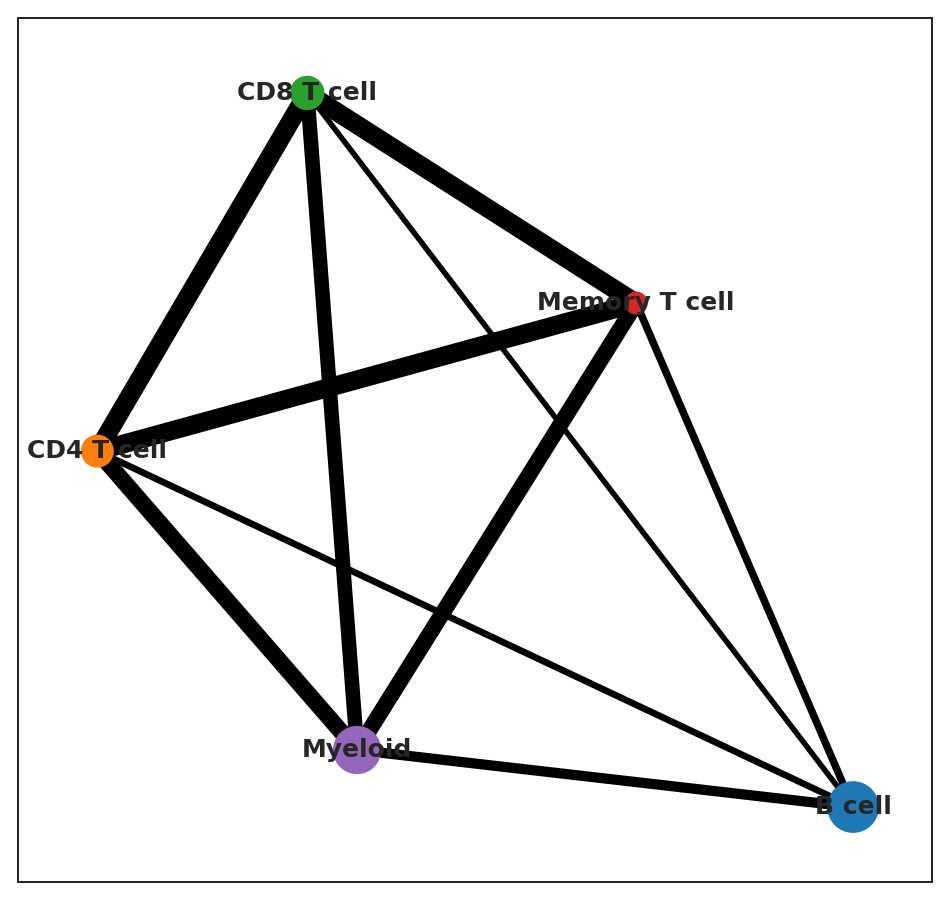

CPU times: user 7.42 s, sys: 424 ms, total: 7.84 s
Wall time: 14.6 s


In [5]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='Cell_Type')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

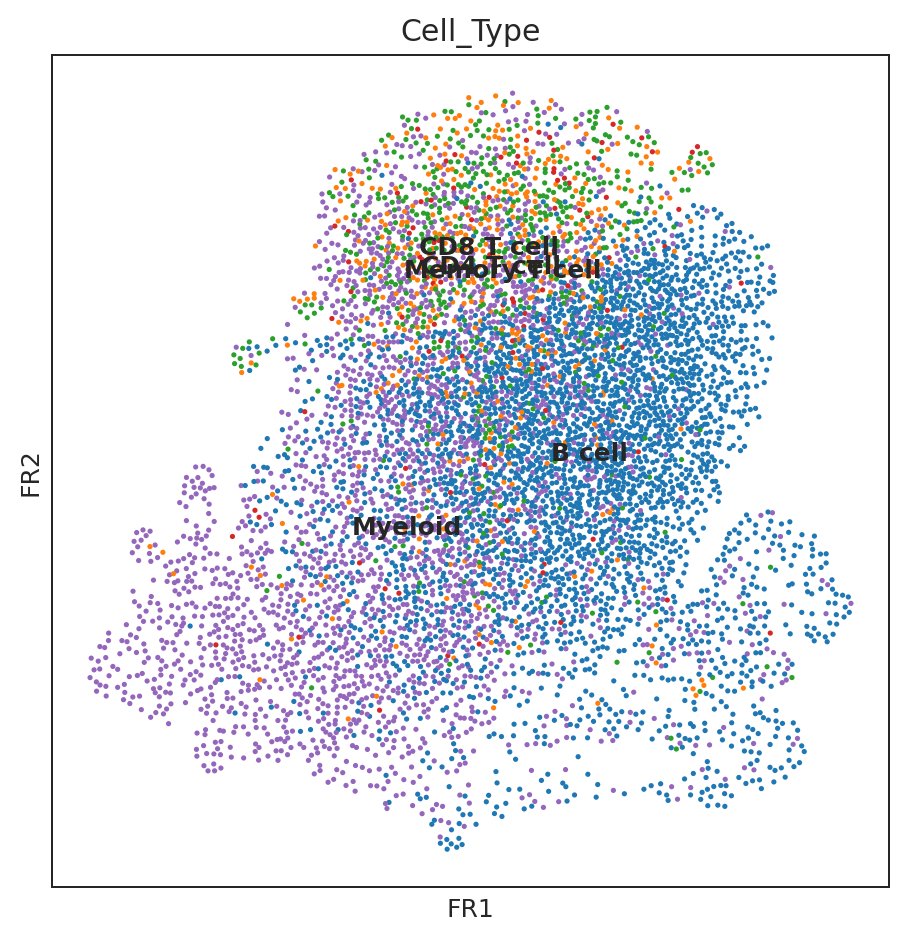

In [6]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='Cell_Type', legend_loc='on data')

In [7]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="Cell_Type",
    embedding_name="X_draw_graph_fr"
)

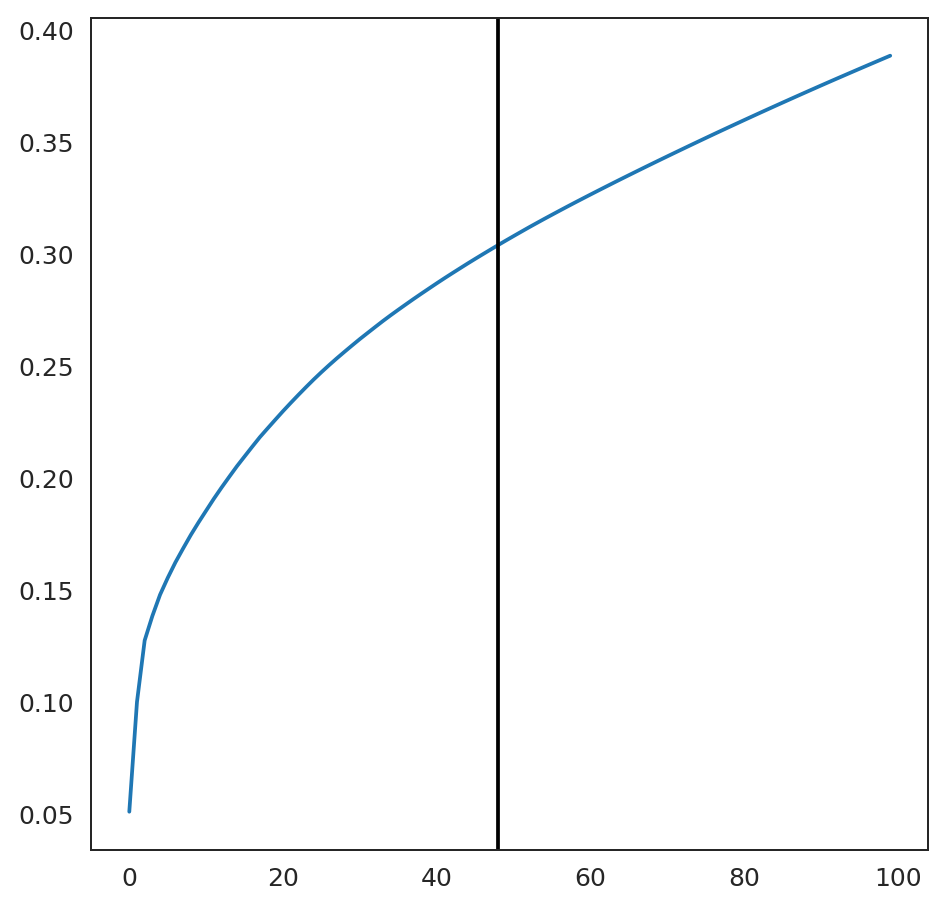

48


In [8]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [9]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :6891
Auto-selected k is :172


In [10]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [11]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [12]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="Cell_Type", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    # n_jobs=8
)

  0%|          | 0/5 [00:00<?, ?it/s]

Inferring GRN for B cell...


  0%|          | 0/2633 [00:00<?, ?it/s]

Inferring GRN for CD4 T cell...


  0%|          | 0/2633 [00:00<?, ?it/s]

Inferring GRN for CD8 T cell...


  0%|          | 0/2633 [00:00<?, ?it/s]

Inferring GRN for Memory T cell...


  0%|          | 0/2633 [00:00<?, ?it/s]

Inferring GRN for Myeloid...


  0%|          | 0/2633 [00:00<?, ?it/s]

CPU times: user 15min 32s, sys: 1.94 s, total: 15min 33s
Wall time: 15min 57s


In [13]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
import pickle

with open('../../data/spleen/celloracle_links.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

with open('/ix/djishnu/shared/djishnu_kor11/training_data/spleen_celloracle.pkl', 'wb') as f:
    pickle.dump(oracle, f)